In [2]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.ar_model import AR

from chitaxi.datasets import loader, builder

# %config InlineBackend.figure_format = 'svg'
%load_ext autoreload
%autoreload 2
plt.style.use('seaborn')
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['legend.facecolor'] = 'w'

from sklearn.model_selection import cross_validate, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error

In [3]:
driver_test = loader.read_feather("Base_Ytest.feather")

df_2015 = loader.read_feather("y_2015.feather")
df_2015.set_index('taxi_id', inplace=True)
df_2016 = loader.read_feather("y_2016.feather")
df_2016.set_index('taxi_id', inplace=True)
df_2015 = df_2015.drop(["Y_total"],axis=1)
df_2016 = df_2016.drop(["Y_total"],axis=1)

df_total = pd.merge(df_2015, df_2016, left_index=True, right_index=True, how="inner")
df_total.columns = range(1,25)
df_total.head()

,1,2,3,4,5,6,7,8,9,10,...,15,16,17,18,19,20,21,22,23,24
taxi_id,,,,,,,,,,,,,,,,,,,,,
0,5194.07,8397.45,8278.91,7619.70,8336.38,11919.99,7111.31,8156.02,10838.18,12135.44,...,7263.11,7719.75,8527.44,7693.81,7219.23,6948.97,5304.79,7371.46,5778.90,4800.85
3,7057.64,6978.48,7944.19,7990.65,8039.19,8295.23,7946.26,7541.35,7370.00,7962.35,...,0.00,0.00,11425.51,13529.23,12293.80,4570.75,7484.22,8465.87,9762.75,3612.45
4,12714.44,13006.38,14486.35,12129.22,12338.93,7939.79,9936.42,9427.46,8534.30,8665.63,...,8418.58,6106.35,6262.71,6488.82,6321.73,6355.37,3670.61,0.00,0.00,0.00
5,5735.53,6137.29,7508.89,2598.04,7298.36,7370.68,7743.12,6914.07,7564.69,9390.64,...,7615.70,7245.69,7746.47,8678.58,7113.90,5851.42,4498.73,5886.77,4739.17,3965.49
6,6113.77,6328.36,8022.46,5436.15,6704.42,8497.32,7747.15,5153.24,6111.51,8009.06,...,3866.86,8657.62,8032.57,8434.20,4331.82,5783.30,7312.12,5545.78,5874.38,5421.13


## Rolling Window AR

In [4]:
ar_test = df_total.loc[driver_test["taxi_id"],:]
for i in range(12):
    ar_test["predict"+str(i+1)] = np.zeros(len(ar_test))

for driver in ar_test.index:
    for m in range(12):
        model = AR(ar_test.loc[driver][m:12+m].values)
        model_fit = model.fit(maxlag=11, ic="aic")
        params=model_fit.params
        lag = len(params)-1
        ar_test.loc[driver, "predict"+str(m+1)] = max(params[0]+ar_test.loc[driver][12+m-lag:m+12].dot(params[1:]),0)

C:\Users\xuhui\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:734: RuntimeWarning: divide by zero encountered in log
  return np.log(self.sigma2) + 2 * (1 + self.df_model)/self.nobs


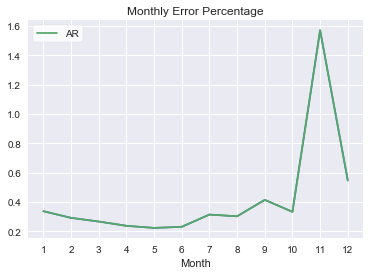

In [26]:
for m in range(12):
    ar_test["abserror"+str(m+1)] = abs(ar_test["predict"+str(m+1)] - ar_test[m+13])

err_pct_monthly =[]
for m in range(12):
    #absolute error sum / monthly trip total sum 
    err_pct_monthly.append(ar_test["abserror"+str(m+1)].mean()/ar_test[m+13].mean())
plt.plot(err_pct_monthly)


plt.plot(err_pct_monthly,label="AR")
plt.legend()
plt.xticks(range(0,12),range(1,13))
plt.xlabel("Month")
plt.title("Monthly Error Percentage")
plt.savefig("Rolling_AR.png", dpi=100)
plt.show()

Driver 3378 contributed to the month 11 (10 in the plot) error.
It has 0 trip totals for several months, causing a lag 1 coefficient of 800, generating an extremely large coefficient.

In [27]:
driver=3378
m=10
model = AR(ar_test.loc[driver][m:12+m].values)
model_fit = model.fit(maxlag=11, ic="aic")
params=model_fit.params
print(params)
lag = len(params)-1
params[0]+ar_test.loc[driver][12+m-lag:m+12].dot(params[1:])

C:\Users\xuhui\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:734: RuntimeWarning: divide by zero encountered in log
  return np.log(self.sigma2) + 2 * (1 + self.df_model)/self.nobs


[7.50000000e-01 8.24541333e+02]


5099632.233813334

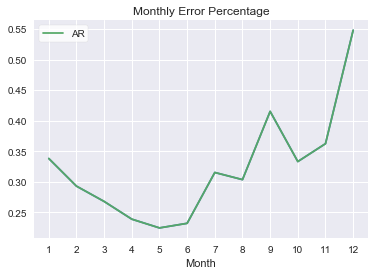

In [25]:
ar_test_removeoutlier = ar_test.drop([3378],axis=0)

err_pct_monthly =[]
for m in range(12):
    err_pct_monthly.append(ar_test_removeoutlier["abserror"+str(m+1)].mean()/ar_test_removeoutlier[m+13].mean())
plt.plot(err_pct_monthly)



plt.plot(err_pct_monthly,label="AR")
plt.legend()
plt.xticks(range(0,12),range(1,13))
plt.xlabel("Month")
plt.title("Monthly Error Percentage")
plt.savefig("Rolling_AR.png", dpi=100)
plt.show()

## Rolling Window - Random Forest

In [9]:
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error

def wrap_results(model, X_train, X_test, y_train, y_test, metric):
    # model.fit(X_train, y_train)
    y_train_predict = model.predict(X_train).flatten()
    y_test_predict = model.predict(X_test).flatten()
    y_train = y_train.values.flatten()
    y_test = y_test.values.flatten()
    res = [
        metric(y_train_predict, y_train),
        metric(y_test_predict, y_test),
        np.mean((np.abs(y_train_predict - y_train) / y_train)),
        np.mean((np.abs(y_test_predict - y_test) / y_test)),
        mean_absolute_error(y_train_predict, y_train) / y_train.mean(),
        mean_absolute_error(y_test_predict, y_test) / y_test.mean()
    ]
    return pd.Series(res, index=['Metric Train', 'Metric Test', 'Ratio Train', 'Ratio Test', 'Ratio 2 Train', 'Ratio 2 Test'])

C:\Users\xuhui\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
C:\Users\xuhui\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
C:\Users\xuhui\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
C:\Users\xuhui\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
C:\Users\xuhui\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
C:\Users\xuhui\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
C:\Users\xuhui\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel imp

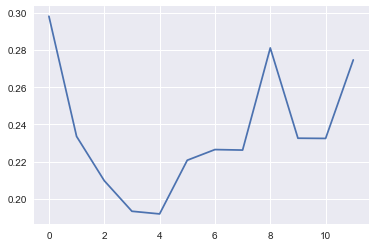

In [12]:
features_2015 = loader.read_feather("2015_features.feather").set_index("taxi_id")
features_2016 = loader.read_feather("2016_features.feather").set_index("taxi_id")
labels_2015 = loader.read_feather("y_2015.feather").set_index("taxi_id")
labels_2016 = loader.read_feather("y_2016.feather").set_index("taxi_id")

features_2016.columns = ['count_13','count_14','count_15','count_16','count_17','count_18','count_19','count_20','count_21','count_22','count_23','count_24','total_daytime0_13','total_daytime1_13','total_daytime0_14','total_daytime1_14','total_daytime0_15','total_daytime1_15','total_daytime0_16','total_daytime1_16','total_daytime0_17','total_daytime1_17','total_daytime0_18','total_daytime1_18','total_daytime0_19','total_daytime1_19','total_daytime0_20','total_daytime1_20','total_daytime0_21','total_daytime1_21','total_daytime0_22','total_daytime1_22','total_daytime0_23','total_daytime1_23','total_daytime0_24','total_daytime1_24','max_break_hrs_13','max_break_hrs_14','max_break_hrs_15','max_break_hrs_16','max_break_hrs_17','max_break_hrs_18','max_break_hrs_19','max_break_hrs_20','max_break_hrs_21','max_break_hrs_22','max_break_hrs_23','max_break_hrs_24','avg_break_hrs_13','avg_break_hrs_14','avg_break_hrs_15','avg_break_hrs_16','avg_break_hrs_17','avg_break_hrs_18','avg_break_hrs_19','avg_break_hrs_20','avg_break_hrs_21','avg_break_hrs_22','avg_break_hrs_23','avg_break_hrs_24','miles_mean_13','miles_mean_14','miles_mean_15','miles_mean_16','miles_mean_17','miles_mean_18','miles_mean_19','miles_mean_20','miles_mean_21','miles_mean_22','miles_mean_23','miles_mean_24','total_25p_13','total_25p_14','total_25p_15','total_25p_16','total_25p_17','total_25p_18','total_25p_19','total_25p_20','total_25p_21','total_25p_22','total_25p_23','total_25p_24','total_50p_13','total_50p_14','total_50p_15','total_50p_16','total_50p_17','total_50p_18','total_50p_19','total_50p_20','total_50p_21','total_50p_22','total_50p_23','total_50p_24','total_75p_13','total_75p_14','total_75p_15','total_75p_16','total_75p_17','total_75p_18','total_75p_19','total_75p_20','total_75p_21','total_75p_22','total_75p_23','total_75p_24','total_mean_13','total_mean_14','total_mean_15','total_mean_16','total_mean_17','total_mean_18','total_mean_19','total_mean_20','total_mean_21','total_mean_22','total_mean_23','total_mean_24','seconds_mean_13','seconds_mean_14','seconds_mean_15','seconds_mean_16','seconds_mean_17','seconds_mean_18','seconds_mean_19','seconds_mean_20','seconds_mean_21','seconds_mean_22','seconds_mean_23','seconds_mean_24','total_sum_13','total_sum_14','total_sum_15','total_sum_16','total_sum_17','total_sum_18','total_sum_19','total_sum_20','total_sum_21','total_sum_22','total_sum_23','total_sum_24','total_workday0_13','total_workday1_13','total_workday0_14','total_workday1_14','total_workday0_15','total_workday1_15','total_workday0_16','total_workday1_16','total_workday0_17','total_workday1_17','total_workday0_18','total_workday1_18','total_workday0_19','total_workday1_19','total_workday0_20','total_workday1_20','total_workday0_21','total_workday1_21','total_workday0_22','total_workday1_22','total_workday0_23','total_workday1_23','total_workday0_24','total_workday1_24']
rename_columns = features_2015.columns

X_train = loader.read_feather("Base_Xtrain.feather").set_index("taxi_id")
X_test = loader.read_feather("Base_Xtest.feather").set_index("taxi_id")

from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(bootstrap= False, max_depth = None, 
                           max_features= 10, min_samples_leaf=3, 
                           min_samples_split=3)


features_total = pd.merge(features_2015, features_2016, left_index=True, right_index=True)
col = ["count_", "total_daytime","max_break_hrs_","avg_break_hrs_",
      "miles_mean_","total_25p_","total_50p_","total_75p_","total_mean_","seconds_mean_",
      "total_sum_","total_workday"]

rf_result_summary = []

for i in range(12):
    new_col = []
    for c in col:
        for m in range(1,13):
            if c =="total_daytime" or c=="total_workday":
                new_col.append(c+"0_"+str(m+i))
                new_col.append(c+"1_"+str(m+i))
            else:
                new_col.append(c+str(m+i))
                
    train_feature_temp = features_total[new_col].loc[X_train.index].copy()
    test_feature_temp = features_total[new_col].loc[X_test.index].copy()
    
    train_feature_temp.columns = rename_columns
    test_feature_temp.columns= rename_columns
    
    
    train_label_temp = labels_2016.loc[X_train.index]["Y_"+str(i+1)]
    test_label_temp = labels_2016.loc[X_test.index]["Y_"+str(i+1)]                
    
    rf.fit(train_feature_temp,train_label_temp)
    rf_results = wrap_results(rf, train_feature_temp, test_feature_temp,
                          train_label_temp, test_label_temp, mean_absolute_error)
    rf_result_summary.append(rf_results["Ratio 2 Test"])




## Comparison

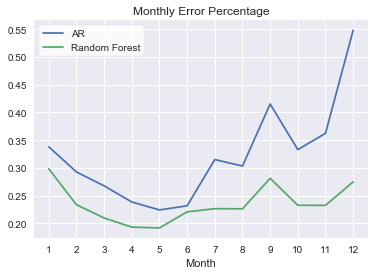

In [24]:
plt.plot(err_pct_monthly,label="AR")
plt.plot(rf_result_summary,label="Random Forest")
plt.legend()
plt.xticks(range(0,12),range(1,13))
plt.xlabel("Month")
plt.title("Monthly Error Percentage")
plt.savefig("Rolling_Analysis.png", dpi=100)
plt.show()